<a href="https://colab.research.google.com/github/yasamankfd/2-functions-With-Thread/blob/master/hematoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Text(0.5, 1.0, 'img 2')

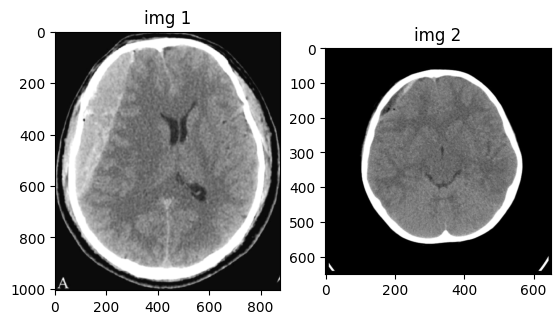

In [48]:
import math
from scipy import fftpack
import os,sys
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
from google.colab import drive
drive.mount("/content/drive/")
os.chdir("/content/drive/My Drive/image proccessing photos/brain ct/")

img1 = cv.imread("hematoma_12.png",cv.IMREAD_GRAYSCALE)
img2 = cv.imread("hematoma_11.jpg",cv.IMREAD_GRAYSCALE)

h1,w2 = img1.shape
h1,w2 = img2.shape

plt.subplot(1,2,1)
plt.imshow(img1,cmap="gray")
plt.title("img 1")

plt.subplot(1,2,2)
plt.imshow(img2,cmap='gray')
plt.title('img 2')



Text(0.5, 1.0, 'blur')

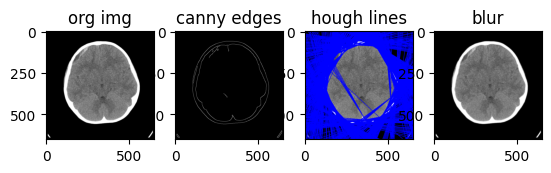

In [ ]:
# Load the image
img1 = cv.imread("hematoma_10.jpg", cv.IMREAD_GRAYSCALE)

# Apply GaussianBlur to reduce noise and improve HoughLines detection
blur = cv.GaussianBlur(img1, (5, 5), 0)

#Apply Canny edge detection
edges = cv.Canny(blur, 50, 150)


#Apply Hough Transform
lines = cv.HoughLines(edges, 1, np.pi / 180, 30)

img_rgb = cv.cvtColor(img1, cv.COLOR_GRAY2RGB)
# Draw lines on the image
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv.line(img_rgb, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Step 6: Thresholding and Image Reconstruction

# Display the results

plt.subplot(1,4,1)
plt.imshow(img1,cmap="gray")
plt.title("org img")

plt.subplot(1,4,2)
plt.imshow(edges,cmap='gray')
plt.title('canny edges')

plt.subplot(1,4,3)
plt.imshow(img_rgb, cmap="gray")
plt.title("hough lines")

plt.subplot(1,4,4)
plt.imshow(blur, cmap="gray")
plt.title("blur")

def edge_detection_canny(image, threshold=120):
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)
    edges = cv2.Canny(blurred_image, 50, 120)  # Using OpenCV's built-in Canny edge detector
    edges = cv2.bitwise_not(edges)
    return edges
# Step 2: Edge detection using improved Canny
edge_image = edge_detection_canny(skull_removed_image)

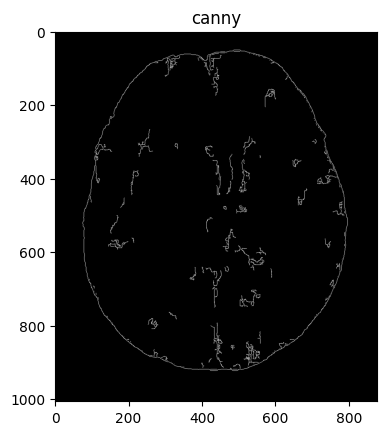

In [45]:
import cv2
import numpy as np

def find_seed_points(image, target_value):
    seed_points = []
    h,w = image.shape

    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if (( ((h/2 -10) <= x <= (h/2 + 10)) and ((w/2 -10) <= y <= (w/2 + 10)) )):#((target_value - 5) <= image[x, y] <= (target_value + 5)) and
                seed_points.append((x, y))

    return seed_points


def region_growing(image):
    seeds = find_seed_points(image,130)
    threshold = 120
    height, width = image.shape[:2]
    segmented = np.full(image.shape, 0, dtype=np.uint8)
    visited = np.zeros_like(image)

    for seed in seeds:
        stack = [seed]

        while stack:
            current_point = stack.pop()
            x, y = current_point

            if 0 <= x < height and 0 <= y < width and not visited[x, y]:
                if abs(int(image[x, y]) - int(image[seed])) < threshold:
                    segmented[x, y] = 255
                    visited[x, y] = 1
                    stack += [
                        (x + 1, y),
                        (x - 1, y),
                        (x, y + 1),
                        (x, y - 1),
                        (x + 1, y + 1),
                        (x - 1, y - 1),
                        (x + 1, y - 1),
                        (x - 1, y + 1),
                    ]

    return segmented


def remove_skull_noise(original_image):
    # Implement region growing algorithm to obtain brain tissue region (Step 1)
    seed_point = (100, 100)  # Choose a seed point

    # brain_region_image = region_growing2(original_image,seed_point)
    brain_region_image = region_growing(original_image)

    #Apply a Gaussian smoothing filter to the resulting segmented region.
    blurred_image = cv2.GaussianBlur(brain_region_image, (5, 5), 0.8)

    # Perform AND operation to remove skull noise (Step 2)
    skull_removed_image = cv2.bitwise_and(original_image, original_image, mask=brain_region_image)

    return brain_region_image , skull_removed_image


def calculate_gradient(image):
    # Sobel operator for horizontal and vertical gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate gradient magnitude and direction
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    gradient_direction = np.arctan2(sobely, sobelx)

    return gradient_magnitude, gradient_direction

def edge_detection(image, threshold=120, min_value=50):
    # Apply 3x3 Gaussian filter as local processing
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0.1)

    # Compare the neighborhood center with the two pixels along the corresponding gradient
    f = blurred_image > threshold
    minValue = cv2.erode(blurred_image, None, iterations=1)

    # Retain pixels where f is non-minimum and greater than the minimum threshold
    edge_image = np.zeros_like(image)
    edge_image[(f) & (blurred_image > minValue)] = 1

    return edge_image

def remove_hematoma_noise(skull_removed_image):
    # Step 1: Edge Detection using Improved Canny Operator
    edges = cv2.Canny(skull_removed_image, 0, 123)

    plt.imshow(edges, cmap="gray")
    plt.title("canny")
    # Step 2: Create Hematoma-Like Noise Image
    hematoma_like_noise = np.zeros_like(skull_removed_image)
    hematoma_like_noise[edges > 0] = 1

    # Step 3: Binary Inversion
    inverted_hematoma_like_noise = cv2.bitwise_not(hematoma_like_noise)

    # Step 4: Combine Binary Inverted Hematoma-Like Noise Image and Skull Removed Image
    noise_reduced_brain_tissue = cv2.bitwise_and(inverted_hematoma_like_noise, skull_removed_image)

    return noise_reduced_brain_tissue


original_image = cv2.imread("hematoma_12.png",cv2.IMREAD_GRAYSCALE)
# Step 1: Remove skull noise
region , skull_removed_image = remove_skull_noise(original_image)
magnitude , direction = calculate_gradient(skull_removed_image)

edge_image = edge_detection(direction, threshold=120, min_value=100)





# Example usage
noise_reduced_image = remove_hematoma_noise(skull_removed_image)


# Visualization
# plt.subplot(1, 6, 1)
# plt.imshow(original_image, cmap="gray")
# plt.title("Brain")

# plt.subplot(1, 6, 2)
# plt.imshow(region, cmap="gray")
# plt.title("Region Img")

# plt.subplot(1, 6, 3)
# plt.imshow(skull_removed_image, cmap="gray")
# plt.title("Skull Removed")

# plt.subplot(1, 6, 4)
# plt.imshow(magnitude, cmap="gray")
# plt.title("Magnitude")

# plt.subplot(1, 6, 5)
# plt.imshow(edge_image, cmap="gray")
# plt.title("Edge Image")
# s_removed = skull_removed_image.astype(np.uint8)
# print(s_removed.dtype)

# plt.subplot(1, 6, 6)
# plt.imshow(noise_reduced_image, cmap="gray")
# plt.title("revised")

#till now we implemented till 2.5 page2 on the right

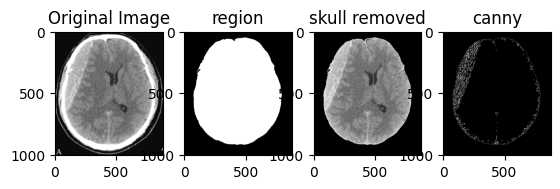

In [69]:
def remove_skull_noise(original_image):
    # brain_region_image = region_growing2(original_image,seed_point)
    brain_region_image = region_growing(original_image)

    # Perform AND operation to remove skull noise (Step 2)
    skull_removed_image = cv2.bitwise_and(original_image, original_image, mask=brain_region_image)
    return brain_region_image , skull_removed_image

def find_seed_points(image, target_value):
    seed_points = []
    h,w = image.shape

    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if (( ((h/2 -10) <= x <= (h/2 + 10)) and ((w/2 -10) <= y <= (w/2 + 10)) )):#((target_value - 5) <= image[x, y] <= (target_value + 5)) and
                seed_points.append((x, y))

    return seed_points


def region_growing(image):
    seeds = find_seed_points(image,130)
    threshold = 120
    height, width = image.shape[:2]
    segmented = np.full(image.shape, 0, dtype=np.uint8)
    visited = np.zeros_like(image)

    for seed in seeds:
        stack = [seed]

        while stack:
            current_point = stack.pop()
            x, y = current_point

            if 0 <= x < height and 0 <= y < width and not visited[x, y]:
                if abs(int(image[x, y]) - int(image[seed])) < threshold:
                    segmented[x, y] = 255
                    visited[x, y] = 1
                    stack += [
                        (x + 1, y),
                        (x - 1, y),
                        (x, y + 1),
                        (x, y - 1),
                        (x + 1, y + 1),
                        (x - 1, y - 1),
                        (x + 1, y - 1),
                        (x - 1, y + 1),
                    ]

    return segmented

def edge_detection_improved_canny(image, threshold=120, min_value=50):
    # Step 1: Apply Gaussian smoothing filter
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)

    # Step 2: Calculate gradient amplitude and direction
    sobelx = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)

    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    gradient_direction = np.arctan2(sobely, sobelx)

    # Step 3: Non-maximum suppression
    dx = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)

    gradient_direction = np.arctan2(dy, dx) * (180 / np.pi)
    gradient_direction[gradient_direction < 0] += 180

    non_max_suppression = np.zeros_like(blurred_image)

    for i in range(1, blurred_image.shape[0] - 1):
        for j in range(1, blurred_image.shape[1] - 1):
            orientation = gradient_direction[i, j]

            q = 255
            r = 255

            if (0 <= orientation < 22.5) or (157.5 <= orientation <= 180):
                q = blurred_image[i, j + 1]
                r = blurred_image[i, j - 1]
            elif 22.5 <= orientation < 67.5:
                q = blurred_image[i + 1, j - 1]
                r = blurred_image[i - 1, j + 1]
            elif 67.5 <= orientation < 112.5:
                q = blurred_image[i + 1, j]
                r = blurred_image[i - 1, j]
            elif 112.5 <= orientation < 157.5:
                q = blurred_image[i - 1, j - 1]
                r = blurred_image[i + 1, j + 1]

            if blurred_image[i, j] >= q and blurred_image[i, j] >= r:
                non_max_suppression[i, j] = blurred_image[i, j]
            else:
                non_max_suppression[i, j] = 0

    # Step 4: Thresholding
    edge_image = np.zeros_like(blurred_image)
    edge_image[non_max_suppression > threshold] = 1

    return edge_image
original_image = cv2.imread("hematoma_12.png",cv2.IMREAD_GRAYSCALE)

region , skull_removed_image = remove_skull_noise(original_image)

# Step 1: Improved Canny Edge Detection
edge_image = edge_detection_improved_canny(skull_removed_image, threshold=170, min_value=50)

inverted_hematoma_image = cv2.bitwise_not(edge_image)

# Visualization
plt.subplot(1, 4, 1)
plt.imshow(original_image.astype(np.float16), cmap="gray")
plt.title("Original Image")

plt.subplot(1, 4, 2)
plt.imshow(region, cmap="gray")
plt.title("region")

plt.subplot(1, 4, 3)
plt.imshow(skull_removed_image, cmap="gray")
plt.title("skull removed")

plt.subplot(1, 4, 4)
plt.imshow(edge_image, cmap="gray")
plt.title("canny")

plt.show()


Text(0.5, 1.0, 'noise eliminated')

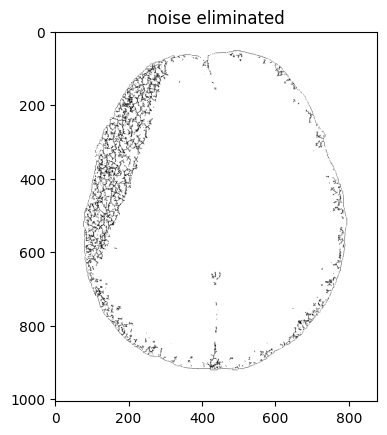

In [70]:
plt.imshow(inverted_hematoma_image, cmap="gray")
plt.title("noise eliminated")

Text(0.5, 1.0, 'noise eliminated')

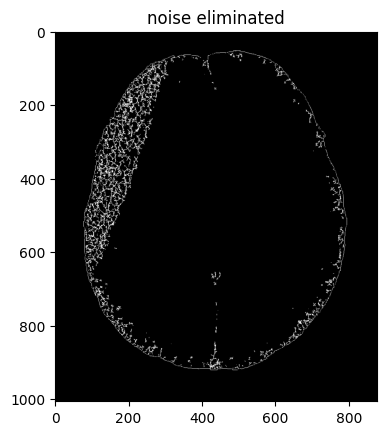

In [72]:
plt.imshow(edge_image, cmap="gray")
plt.title("noise eliminated")

Text(0.5, 1.0, 'noise eliminated')

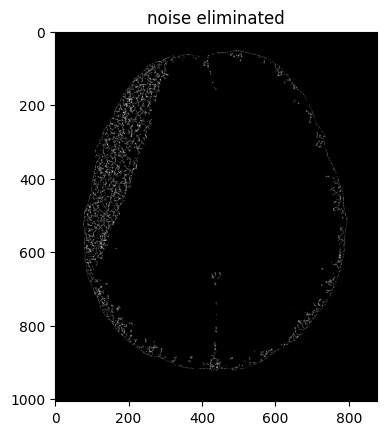

In [71]:
result_image = cv2.bitwise_and(cv2.bitwise_not(inverted_hematoma_image), skull_removed_image)
plt.imshow(result_image, cmap="gray")
plt.title("noise eliminated")